In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from category_encoders import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

#from xgboost import XGBRegressor

# Data Cleaning

In [4]:
# # unzip files
# !unzip Other/Inpatient_Data_2011_CSV.zip
# !unzip Other/Inpatient_Data_2012_CSV.zip
# !unzip Other/Inpatient_Data_2013_CSV.zip
# !unzip Other/Inpatient_Data_2014_CSV.zip
# !unzip Other/Inpatient_Data_2015_CSV.zip
# !unzip Other/Inpatient_Data_2016_CSV.zip

In [5]:
# load data into pandas
top_2011 = pd.read_csv('Data/Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv')
top_2012 = pd.read_csv('Data/Medicare_Provider_Charge_Inpatient_DRG100_FY2012.csv')
top_2013 = pd.read_csv('Data/Medicare_Provider_Charge_Inpatient_DRG100_FY2013.csv')
og_2014 = pd.read_csv('Data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2014.csv')
og_2015 = pd.read_csv('Data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2015.csv')
og_2016 = pd.read_csv('Data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2016.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# define top100 list
top100 = top_2011['DRG Definition'].unique().tolist()

In [7]:
# get diagnoses from top 100
top_2014 = og_2014[og_2014['DRG Definition'].isin(top100)]
top_2015 = og_2015[og_2015['DRG Definition'].isin(top100)]
top_2016 = og_2016[og_2016['DRG Definition'].isin(top100)]

In [8]:
# add year feature
top_2011['year'] = [2011] * top_2011.shape[0]
top_2012['year'] = [2012] * top_2012.shape[0]
top_2013['year'] = [2013] * top_2013.shape[0]
top_2014['year'] = [2014] * top_2014.shape[0]
top_2015['year'] = [2015] * top_2015.shape[0]
top_2016['year'] = [2016] * top_2016.shape[0]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

In [9]:
# 2016 has a '$' in front of `Average Total Payments`
def strip_dollar(entry):
    return float((entry.strip('$')).replace(',', ''))

top_2016['Average Total Payments'] = top_2016['Average Total Payments'].apply(strip_dollar)
top_2016['Average Medicare Payments'] = top_2016['Average Medicare Payments'].apply(strip_dollar)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
# concatenate dataframes
dataframes = [top_2011, top_2012, top_2013, top_2014, top_2015, top_2016]
top100 = pd.concat(dataframes)

In [11]:
# change name
top100['diagnosis'] = top100['DRG Definition']
top100 = top100.drop(columns='DRG Definition')

In [12]:
# drop columns
top100_clean = top100.drop(columns=['Provider Id',
                     'Provider Name',
                     'Provider Street Address',
                     'Provider City',
                     'Provider Zip Code',
                     'Hospital Referral Region (HRR) Description',
                     'Total Discharges',
                     'Average Covered Charges'])

In [13]:
# create out-of-pocket payment feature
top100_clean['cost'] = top100_clean['Average Total Payments'] - top100_clean['Average Medicare Payments']

# now drop other payment features
top100 = top100_clean.drop(columns=['Average Total Payments',
                                    'Average Medicare Payments'])

In [14]:
# get rid of beginning
def strip_beginning(entry):
    return str(entry)[6:]

top100['diagnosis'] = top100['diagnosis'].apply(strip_beginning)

In [15]:
# get rid of endings
endings = [' W/O CC/MCC',
           ' W/O MCC',
           ' W MCC',
           ' W CC',
           ' W/O CC',
           ' W CC/MCC']

def strip_endings(entry):
    for ending in endings:
        if entry.endswith(ending):
            return entry.replace(ending, '')
            
top100['diagnosis'] = top100['diagnosis'].apply(strip_endings)

In [16]:
# categorize diagnoses
diagnoses = top100['diagnosis'].unique().tolist()

# neuro
neuro = diagnoses[:3] + diagnoses[4:6]

# respiratory
respiratory = diagnoses[6:11]

# circulatory
circulatory = diagnoses[11:25]

# digestive
digestive = diagnoses[25:33]

# orthopedic
orthopedic = diagnoses[33:41] + diagnoses[53:]

# PCP
pcp = diagnoses[41:44]

# nephrology
nephrology = diagnoses[44:47]

# other
other = diagnoses[47:53] + diagnoses[3:4]

In [17]:
def categorize(diagnosis):
    if diagnosis in neuro:
        return 'Neurological'
    elif diagnosis in respiratory:
        return 'Respiratory'
    elif diagnosis in circulatory:
        return 'Circulatory'
    elif diagnosis in digestive:
        return 'Digestive'
    elif diagnosis in orthopedic:
        return 'Orthopedic'
    elif diagnosis in pcp:
        return 'PCP'
    elif diagnosis in nephrology:
        return 'Nephrology'
    elif diagnosis in other:
        return 'Other'
    else:
        return 'Other'

In [18]:
# categorize diagnoses
top100['diagnosis'] = top100['diagnosis'].apply(categorize)

# Encode & Impute

In [19]:
# instantiate encoder
encoder = OrdinalEncoder()

In [20]:
encoded = encoder.fit_transform(top100)

In [21]:
# instantiate imputer
imputer = SimpleImputer(np.nan, strategy='median')

In [22]:
imputed = pd.DataFrame(imputer.fit_transform(encoded), columns = encoded.columns.values)

In [23]:
imputed.head()

,Provider State,year,diagnosis,cost
0,1.0,2011.0,1.0,1013.505494
1,1.0,2011.0,1.0,810.857143
2,1.0,2011.0,1.0,981.166666
3,1.0,2011.0,1.0,1288.400000
4,1.0,2011.0,1.0,806.888889


In [41]:
# replace zeroes with ones
def zero_to_one(entry):
    if entry == 0:
        return 1
    else:
        return entry

In [43]:
# replace
imputed['cost'] = imputed['cost'].apply(zero_to_one)

# Train/Test Split

In [44]:
# train/test split
train = pd.concat([imputed[imputed['year'] == 2011],
           imputed[imputed['year'] == 2012],
           imputed[imputed['year'] == 2013],
           imputed[imputed['year'] == 2014],
           imputed[imputed['year'] == 2015]])

test = imputed[imputed['year'] == 2016]

In [45]:
# define target and features
target = 'cost'
features = ['diagnosis', 'Provider State']

In [46]:
# X matrices
X_train = train[features]
X_test = test[features]

# y vector
y_train = train[target]
y_test = test[target]

# Baseline Model

In [47]:
# define error metric
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [48]:
# find median cost
median = train['cost'].median()

# predictions
y_pred = [median] * len(test)

# accuracy
print("RMSE:", rmse(y_test, y_pred))

RMSE: 1546.465099275328


# RF

In [49]:
# instantiate model
rf = RandomForestRegressor()

# fit model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# accuracy
print("RMSE:", rmse(y_test, y_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1409.8947893435613


In [50]:
## Log transformed
y_log_train = np.log(y_train)
y_log_test = np.log(y_test)

In [53]:
# instantiate model
rf = RandomForestRegressor()

# fit model
rf.fit(X_train, y_log_train)

# predict
y_pred = np.exp(rf.predict(X_test))

# accuracy
print("RMSE:", rmse(y_test, y_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE: 1466.8918726282084


In [ ]:
# instantiate model
rf = RandomForestRegressor()

# fit model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# accuracy
print("RMSE:", rmse(y_test, y_pred))

# XGBoost Regressor

KeyboardInterrupt: 

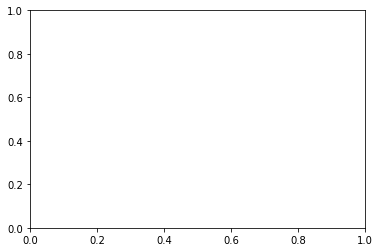

In [34]:
imputed['cost'].plot.density()
plt.show()

In [33]:
plt.show()